### IMPORTS

In [ ]:
import os, logging

import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# Disable warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow_hub").setLevel(logging.CRITICAL)

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
import tensorflow as tf
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import string, random
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow_hub as hub

### Hashira da pedra (rodar aqui p baixo)

####IMPORTS

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

# Clear any logs from previous runs.
!rm -rf ./logs/

Python version: 3.8.16
Tensorflow version: 2.9.2
Keras version: 2.9.0


### DATABASE

#### Load database

In [ ]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling tmp/rock_paper_scissors/3.0.0.incompleteWYR5OZ/rock_paper_scissors-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling tmp/rock_paper_scissors/3.0.0.incompleteWYR5OZ/rock_paper_scissors-test.tfrecord*...:   0%|         …

Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [ ]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

In [ ]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = 128
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)


INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

In [ ]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [ ]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [ ]:
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (128, 128, 3) 

[[[0.99521387 0.99521387 0.99521387]
  [0.99607843 0.99607843 0.99607843]
  [0.9939281  0.9939281  0.9939281 ]
  ...
  [0.9838513  0.9838513  0.9838513 ]
  [0.9856216  0.9856216  0.9856216 ]
  [0.98129785 0.98129785 0.98129785]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9960181  0.9960181  0.9960181 ]
  [0.99601716 0.99601716 0.99601716]
  ...
  [0.9818407  0.9818407  0.9818407 ]
  [0.984375   0.984375   0.984375  ]
  [0.98169994 0.98169994 0.98169994]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.9953719  0.9953719  0.9953719 ]
  ...
  [0.9859232  0.9859232  0.9859232 ]
  [0.98425245 0.98425245 0.98425245]
  [0.97992975 0.97992975 0.97992975]]

 ...

 [[0.98749423 0.98749423 0.98749423]
  [0.9882133  0.9882133  0.9882133 ]
  [0.986736   0.986736   0.986736  ]
  ...
  [0.972549   0.972549   0.972549  ]
  [0.97391427 0.97391427 0.97391427]
  [0.9755237  0.9755237  0.9755237 ]]

 [[0.9907878  0.9907878  0.9907878

####Aumento de dados

In [ ]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [ ]:
dataset_train_augmented = dataset_train.map(augment_data)

####Batching

In [ ]:
BATCH_SIZE = 800

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [ ]:
print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


Label batch shape: (800,) 

Image batch shape: (800, 128, 128, 3) 

Label batch: [2 2 0 1 0 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 2 0 0 2 2 2 0 1
 2 1 0 0 0 0 0 1 1 2 2 0 0 2 1 1 0 0 1 2 1 0 0 0 0 1 2 1 1 2 2 1 1 1 1 1 2
 0 0 2 1 0 1 0 0 1 1 1 1 2 1 1 0 0 2 2 1 0 0 1 1 2 1 1 0 0 0 2 0 0 1 1 2 0
 2 0 1 1 1 2 0 1 0 1 2 1 0 1 2 2 0 2 1 0 0 1 0 1 0 1 2 1 2 2 1 0 2 0 1 1 2
 0 2 2 1 0 1 2 2 1 1 0 2 0 0 1 1 0 1 2 2 0 0 2 1 1 0 1 2 0 1 1 1 2 0 2 1 2
 1 1 1 2 2 2 1 0 2 0 1 0 1 2 0 0 2 0 1 1 0 2 2 2 1 1 1 0 1 0 2 0 0 1 1 1 2
 1 2 1 2 2 0 2 1 0 1 0 0 2 1 1 0 2 2 2 0 1 1 1 2 0 1 0 2 1 1 2 1 2 2 0 1 2
 2 0 2 1 0 2 0 0 1 0 2 2 0 0 2 2 0 0 2 2 1 0 0 0 2 1 1 0 2 0 1 1 1 2 1 1 0
 1 1 2 2 2 1 2 0 0 0 2 0 2 0 0 0 0 2 2 0 1 0 0 1 1 0 1 1 0 2 1 0 2 0 1 1 0
 2 1 0 0 1 2 2 0 1 1 2 2 2 0 2 2 2 0 2 1 2 0 2 1 0 1 1 1 0 2 0 1 0 1 0 0 0
 0 1 2 1 0 2 2 0 2 2 2 1 2 1 2 0 1 0 0 0 1 1 1 1 1 2 1 1 1 0 1 0 2 0 0 1 0
 0 2 0 0 1 1 1 1 2 2 2 1 1 0 1 2 0 1 2 0 0 1 1 0 2 2 1 2 2 1 1 0 2 1 2 2 0
 1 0 0 1 2 0 2 1 1 

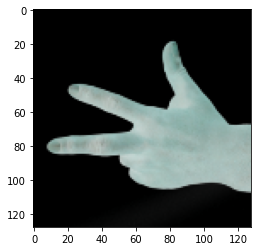

In [ ]:
# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(dataset_train_augmented_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')

    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break

In [ ]:
len(batches)

4

In [ ]:
label_batch.shape

(800,)

### MODELO

####Gerando o Modelo

In [ ]:
INPUT_IMG_SHAPE

NameError: ignored

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE,
  include_top=False,
  weights='imagenet',
  pooling='avg'
)
base_model.trainable = False
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

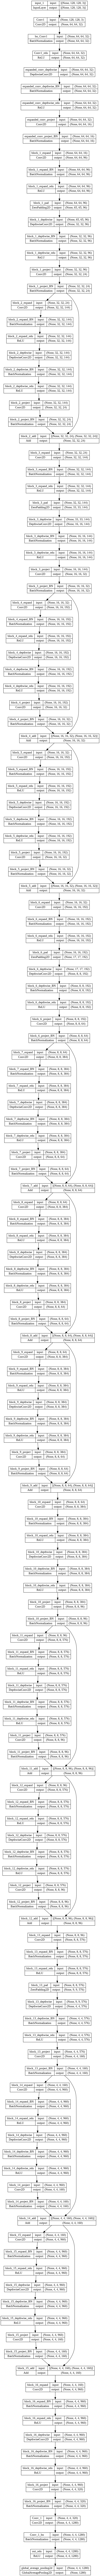

In [ ]:
#plotando esquema do modelo
tf.keras.utils.plot_model(
    base_model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
model = tf.keras.models.Sequential()

model.add(base_model)

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


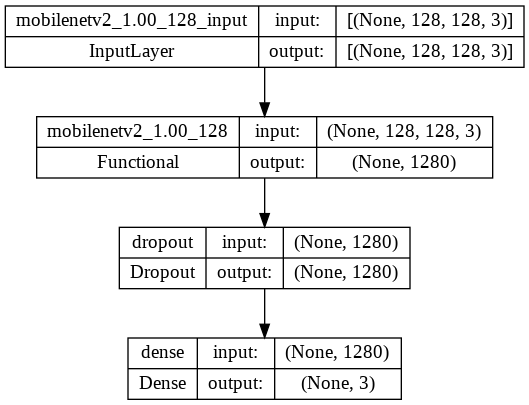

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

####Compilando o modelo

In [ ]:
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

####Treinando o modelo

In [ ]:
NUM_TRAIN_EXAMPLES

2520

In [ ]:
BATCH_SIZE

800

In [ ]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE if NUM_TEST_EXAMPLES // BATCH_SIZE else 1

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 3
validation_steps: 1


In [ ]:
!rm -rf tmp/checkpoints
!rm -rf logs

In [ ]:
# Preparing callbacks e epochs
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_accuracy'
    # monitor='val_loss'
)

initial_epochs = 20

In [ ]:
dataset_train_augmented_shuffled

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
len(dataset_train_augmented_shuffled)

4

In [ ]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/20
3/3 [==============================] - 27s 5s/step - loss: 1.5297 - accuracy: 0.4067 - val_loss: 1.1038 - val_accuracy: 0.5188
Epoch 2/20
3/3 [==============================] - 12s 5s/step - loss: 1.1343 - accuracy: 0.5366 - val_loss: 1.0836 - val_accuracy: 0.5323
Epoch 3/20
3/3 [==============================] - 7s 3s/step - loss: 0.9688 - accuracy: 0.6076 - val_loss: 0.9067 - val_accuracy: 0.6129
Epoch 4/20
3/3 [==============================] - 7s 3s/step - loss: 0.8608 - accuracy: 0.6552 - val_loss: 0.8121 - val_accuracy: 0.6371
Epoch 5/20
3/3 [==============================] - 11s 4s/step - loss: 0.7615 - accuracy: 0.6892 - val_loss: 0.7307 - val_accuracy: 0.6962
Epoch 6/20
3/3 [==============================] - 9s 4s/step - loss: 0.6860 - accuracy: 0.7320 - val_loss: 0.8032 - val_accuracy: 0.6425
Epoch 7/20
3/3 [==============================] - 7s 3s/step - loss: 0.6558 - accuracy: 0.7535 - val_loss: 0.6848 - val_accuracy: 0.7043
Epoch 8/20
3/3 [======================

####Avaliando o modelo

In [ ]:
a = np.array(dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES))

In [ ]:
a

array(<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
      dtype=object)

In [ ]:
dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
dataset_train.batch(BATCH_SIZE)

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES) #utilizar como x_train para avaliacao
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES) #utilizar como x_test para avaliacao
)

1/1 [==============================] - 0s 400ms/step - loss: 0.3404 - accuracy: 0.8817


In [ ]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  0.171097531914711
Training accuracy:  0.9797618985176086


Test loss:  0.34036561846733093
Test accuracy:  0.8817204236984253


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
x_train = dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
x_test = dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)

In [ ]:
predictions = model.predict(x_train)

4/4 [==============================] - 3s 500ms/step


In [ ]:
len(predictions)

2520

####Salvando modelo

In [ ]:
import pickle

In [ ]:
with open('jokenpo.h5', 'wb') as file:
    pickle.dump(model, file)

###IT'S EMBEDDED TIME

####Carrega modelo pre-treinado

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

model_path = "/content/drive/MyDrive/rps_mobilenet_v2.h5"
base_model = tf.keras.models.load_model(model_path)

In [ ]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


####Dataset

In [ ]:
!pip install -U pillow
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 4.6 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [ ]:
TRAIN_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/rps.zip'

zip_path = keras.utils.get_file('rps.zip', origin=TRAIN_URL, extract=True)
train_path = os.path.join(os.path.dirname(zip_path), 'rps')


TEST_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/rps-test-set.zip'

zip_path = keras.utils.get_file('rps-test-set.zip', origin=TEST_URL, extract=True)
test_path = os.path.join(os.path.dirname(zip_path), 'rps-test-set')

29516758/29516758 [==============================] - 0s 0us/step


In [ ]:
INPUT_SIZE = 128
BATCH_SIZE = 70
classes = ['rock', 'paper', 'scissors']

In [ ]:
def string_to_one_hot(label):
    one_hot = tf.stack([tf.equal(label, s) for s in classes], axis=-1)
    one_hot = tf.cast(one_hot, tf.float32)

    return one_hot

In [ ]:
def get_label_from_filename(filename):
    label = tf.strings.split(filename, os.path.sep)[-2]
    label = string_to_one_hot(label)

    return filename, label

In [ ]:
def load_and_preprocess_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, size=(INPUT_SIZE, INPUT_SIZE))

    return image, label

In [ ]:
'''def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((INPUT_SIZE, INPUT_SIZE), Image.ANTIALIAS)
    image = np.asarray(image, dtype=np.float32)
    image = image/255
    image = np.expand_dims(image, axis=0)

    return image'''

In [ ]:
dataset = tf.data.Dataset.list_files(str(test_path+'/*/*'), shuffle=True)
dataset = dataset.map(get_label_from_filename, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

Classe: rock


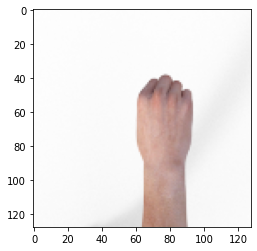

In [ ]:
image, label = next(iter(dataset))
print("Classe: %s" % classes[tf.argmax(label[0])])
plt.imshow(image[0])

In [ ]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

###Sem otimização

####Salvando modelo sem otimização

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()
with open('rps_mobilenet_v2_lite.tflite', 'wb') as f:
    f.write(tflite_model)

####testando modelo sem otimizacao

In [ ]:
def load_model(model_path='/content/drive/MyDrive/rps_mobilenet_v2_lite.tflite'):
    interpreter = tf.lite.Interpreter(model_path)
    interpreter.allocate_tensors()

    return interpreter

In [ ]:
interpreter = load_model()

In [ ]:
interpreter.get_input_details()

[{'name': 'serving_default_mobilenetv2_1.00_128_input:0',
  'index': 0,
  'shape': array([  1, 128, 128,   3], dtype=int32),
  'shape_signature': array([ -1, 128, 128,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 177,
  'shape': array([1, 3], dtype=int32),
  'shape_signature': array([-1,  3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], np.array([image[0]]))
interpreter.invoke()

In [ ]:
output_details = interpreter.get_output_details()
interpreter.get_tensor(output_details[0]['index'])

array([[0.9767785 , 0.02111272, 0.00210877]], dtype=float32)

In [ ]:
base_model.predict(image)

3/3 [==============================] - 9s 121ms/step


array([[9.76778269e-01, 2.11128406e-02, 2.10881094e-03],
       [2.37415507e-02, 9.73547399e-01, 2.71105208e-03],
       [9.72988382e-02, 2.52778623e-02, 8.77423286e-01],
       [1.54600115e-02, 9.04216664e-04, 9.83635724e-01],
       [6.18797660e-01, 3.73077393e-01, 8.12495966e-03],
       [9.81587350e-01, 1.78750604e-02, 5.37617248e-04],
       [9.96853530e-01, 2.97953491e-03, 1.66905069e-04],
       [8.92633274e-02, 2.59812549e-02, 8.84755433e-01],
       [9.69998062e-01, 1.99508704e-02, 1.00511657e-02],
       [3.19661689e-03, 9.96609211e-01, 1.94263936e-04],
       [7.07008168e-02, 3.88117395e-02, 8.90487432e-01],
       [1.75437376e-01, 6.97133005e-01, 1.27429530e-01],
       [9.23061728e-01, 6.96116537e-02, 7.32663879e-03],
       [9.45729792e-01, 4.85128462e-02, 5.75737515e-03],
       [8.57016623e-01, 1.21295638e-01, 2.16877535e-02],
       [9.93979216e-01, 5.74313058e-03, 2.77588842e-04],
       [5.63786089e-01, 9.89580620e-03, 4.26318139e-01],
       [9.96286154e-01, 2.49900

In [ ]:
def load_model(model_path):
    interpreter = tf.lite.Interpreter(model_path)
    interpreter.allocate_tensors()

    return interpreter

In [ ]:
def classify_image(interpreter, image):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])

    return predictions[0]

In [ ]:
tflite_savedModel = load_model('/content/drive/MyDrive/rps_mobilenet_v2_lite.tflite')
classify_image(tflite_savedModel, np.array([image[0]]))

array([0.9767785 , 0.02111272, 0.00210877], dtype=float32)

### Acurácia

In [ ]:
def evaluate_tflite_model(interpreter, dataset):
    labels = []
    predictions = []
    for image, label in dataset:
        labels.append(np.argmax(label[0]))
        pred = classify_image(interpreter, np.array([image[0]]))
        predictions.append(np.argmax(pred))

        if len(labels) % 50 == 0:
            print('.', end='')

    print('\nAccuracy: %.2f%%' % (100*accuracy_score(labels, predictions)))
    print('\nPrecision: %.2f%%' % (100*precision_score(labels, predictions, average="macro")))
    print('\nF1-score: %.2f%%' % (100*f1_score(labels, predictions, average="macro")))
    print('\nRecall-score: %.2f%%' % (100*recall_score(labels, predictions, average="macro")))
    # return 100*accuracy_score(labels, predictions)

In [ ]:
evaluate_tflite_model(tflite_savedModel, dataset)


Accuracy: 100.00%


NameError: ignored

###Com otimização

In [ ]:
%%capture
!pip install -q tensorflow-model-optimization

In [ ]:
import tensorflow_model_optimization as tfmot

####Comparando os modelos